In [ ]:
!pip install -U sentence_transformers

     |████████████████████████████████| 78 kB 3.6 MB/s 
     |████████████████████████████████| 3.3 MB 11.0 MB/s 
     |████████████████████████████████| 3.3 MB 35.3 MB/s 
     |████████████████████████████████| 1.2 MB 48.8 MB/s 
     |████████████████████████████████| 61 kB 469 kB/s 
     |████████████████████████████████| 895 kB 49.2 MB/s 
     |████████████████████████████████| 596 kB 44.3 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=121000 sha256=abaa36e55486ae1696f6874184c7b8f470dc11f4ca28373056b25ee3733ec950
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
#Importing the dataset

from sentence_transformers import SentenceTransformer, util
import pandas as pd
import numpy as np
import torch
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
#Converting into a model
model = SentenceTransformer('allenai/scibert_scivocab_uncased') ##Scibert model used for scientific data -> Gives improved embeddings
#model = SentenceTransformer('sentence-transformers/stsb-roberta-large')
model.max_seq_length = 512

Downloading:   0%|          | 0.00/437 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/442M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/228k [00:00<?, ?B/s]

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/allenai_scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
import json

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip /content/drive/MyDrive/arxiv-metadata-oai-snapshot.json.zip

In [ ]:
# import os
# import shutil

In [ ]:
# shutil.copy('/content/arxiv-metadata-oai-snapshot.json','/content/drive/MyDrive/NNFL Dataset ArXiv')

In [ ]:
#Extracting the json 

data_file = r'/content/drive/MyDrive/NNFL Dataset ArXiv/arxiv-metadata-oai-snapshot.json'
""" Using `yield` to load the JSON file in a loop to prevent Python memory issues if JSON is loaded directly"""
print(data_file)
def get_metadata():
    with open(data_file, 'r') as f:
        for line in f:
            yield line

/content/drive/MyDrive/NNFL Dataset ArXiv/arxiv-metadata-oai-snapshot.json


In [ ]:
#Getting the metadata from the json
metadata = get_metadata()
ids = []
titles = []
abstracts = []
categories = []
count = 0
for paper in metadata:
    count+=1
    metaDict = json.loads(paper)
    try:
        try:
            year = int(metaDict['journal-ref'][-4:])    ## Example Format: "Phys.Rev.D76:013009,2007"
        except:
            year = int(metaDict['journal-ref'][-5:-1])    ## Example Format: "Phys.Rev.D76:013009,(2007)"
        if(year == 2021):
            ids.append(metaDict['id'])
            titles.append(metaDict['title'])
            abstracts.append(metaDict['abstract'])
            categories.append(metaDict['categories'])
    except:
        pass
print(count)

1980931


In [ ]:
#Converting the metadata into dataframe
df = pd.DataFrame({'id' : ids,'title' : titles,'abstract' : abstracts, 'categories' : categories})


print(len(df))

26506


In [ ]:
df.head()

,id,title,abstract,categories
0,0805.3666,On the derivation of exact eigenstates of the ...,We construct the states that are invariant u...,quant-ph
1,0906.1672,On Path diagrams and Stirling permutations,A permutation can be locally classified acco...,math.CO
2,0906.5460,Onset of inertial magnetoconvection in rotatin...,The onset of convection in the form of magne...,physics.flu-dyn physics.geo-ph
3,0910.2348,A model of compact polymers on a family of thr...,We study Hamiltonian walks (HWs) on the fami...,cond-mat.stat-mech cond-mat.soft
4,1001.4838,A systematic approach to the Planck LFI end-to...,The Level 1 of the Planck LFI Data Processin...,astro-ph.IM astro-ph.CO


In [ ]:
cat_list= df['categories'].unique() ## Store the list of categories

In [ ]:
#getting the rows corresponding to ML category
ml_df = df[df['categories'].str.contains("cs.LG")]
#storing the abstracts
sentencesList= ml_df['abstract'].tolist()

In [ ]:
print(len(ml_df))

1315


In [ ]:
print(sentencesList[0])

  Inference of hidden classes in stochastic block model is a classical problem
with important applications. Most commonly used methods for this problem
involve na\"{\i}ve mean field approaches or heuristic spectral methods.
Recently, belief propagation was proposed for this problem. In this
contribution we perform a comparative study between the three methods on
synthetically created networks. We show that belief propagation shows much
better performance when compared to na\"{\i}ve mean field and spectral
approaches. This applies to accuracy, computational efficiency and the tendency
to overfit the data.



In [ ]:
ml_df.iloc[1]['id']

'1505.05629'

In [ ]:
import time
start_time = time.time()
#computing the sntence embeddings for all the abstracts
embeddings = model.encode(sentencesList, convert_to_tensor=True)
end_time = time.time()
print("Time for computing embeddings:"+ str(end_time-start_time) )

Time for computing embeddings:61.76654267311096


In [ ]:
#checking embedding size
print(np.shape(embeddings))

torch.Size([1315, 768])


tensor([[1.0000, 0.8980, 0.8712,  ..., 0.8803, 0.8729, 0.8551],
        [0.8980, 1.0000, 0.8933,  ..., 0.8871, 0.8566, 0.8877],
        [0.8712, 0.8933, 1.0000,  ..., 0.8903, 0.8582, 0.9095],
        ...,
        [0.8803, 0.8871, 0.8903,  ..., 1.0000, 0.8760, 0.8881],
        [0.8729, 0.8566, 0.8582,  ..., 0.8760, 1.0000, 0.8643],
        [0.8551, 0.8877, 0.9095,  ..., 0.8881, 0.8643, 1.0000]],
       device='cuda:0')


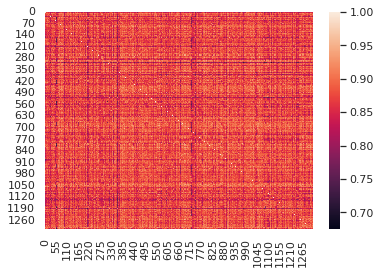

In [ ]:
#Calculating the cosine scores of every abstract with every other abstract
cosine_scores = util.pytorch_cos_sim(embeddings, embeddings)
print(cosine_scores)
sns.set_theme()
cosine_scores_list = cosine_scores.tolist()
sns.heatmap(cosine_scores_list)

In [ ]:
#Displaying the most similar abstract to a particular abstract
count = 0
for scores in cosine_scores:
    scores[count]=0.0
    max_elements, max_indices = torch.max(scores,dim=0)
    max_index = max_indices.item()
    print("\n*********\n")
    print("**Paper Id :"+ml_df.iloc[count]['id']+' '+'\nTitle :'+ml_df.iloc[count]['title']
          +'\n'+ml_df.iloc[count]['abstract']+
          '\n**Paper Id :' +ml_df.iloc[max_index]['id']+' '+'\nTitle :'+
          ml_df.iloc[max_index]['title']+'\n'+
          ml_df.iloc[max_index]['abstract'])
    count =count+1

Streaming output truncated to the last 5000 lines.
  Graph-based subspace clustering methods have exhibited promising performance.
However, they still suffer some of these drawbacks: encounter the expensive
time overhead, fail in exploring the explicit clusters, and cannot generalize
to unseen data points. In this work, we propose a scalable graph learning
framework, seeking to address the above three challenges simultaneously.
Specifically, it is based on the ideas of anchor points and bipartite graph.
Rather than building a $n\times n$ graph, where $n$ is the number of samples,
we construct a bipartite graph to depict the relationship between samples and
anchor points. Meanwhile, a connectivity constraint is employed to ensure that
the connected components indicate clusters directly. We further establish the
connection between our method and the K-means clustering. Moreover, a model to
process multi-view data is also proposed, which is linear scaled with respect
to $n$. Extensive exp

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
print(len(embeddings))

1315


In [ ]:
print(np.shape(embeddings))

torch.Size([1315, 768])


In [ ]:
print(np.shape(cosine_scores))

torch.Size([1315, 1315])


In [ ]:
#Manually inputting an abstract to find out the most similar abstract
abstract = "We propose the ChaCha (Champion-Challengers) algorithm for making an online \
choice of hyperparameters in online learning settings. ChaCha handles the \
process of determining a champion and scheduling a set of `live' challengers \
over time based on sample complexity bounds. It is guaranteed to have sublinear \
regret after the optimal configuration is added into consideration by an \
application-dependent oracle based on the champions. Empirically, we show that \
ChaCha provides good performance across a wide array of datasets when \
optimizing over featurization and hyperparameter decisions."

In [ ]:
import time
start_time = time.time()
#Calculating embedding for a single abstract
embeddingsAbstract = model.encode(abstract, convert_to_tensor=True)
#Calculating the embedding for all the abstracts
embeddingsAll = model.encode(sentencesList, convert_to_tensor=True)
end_time = time.time()
print("Time for computing embeddings:"+ str(end_time-start_time) )

Time for computing embeddings:49.03672742843628


In [ ]:
print(np.shape(embeddingsAll))
print(np.shape(embeddingsAbstract))

torch.Size([1315, 768])
torch.Size([768])


In [ ]:
#Function to get the second larget cosine score which will be the most similar abstract as the largest cosine score will be 1 which is for itself.
def getSecondLargest(cosine_list):
  mx=max(cosine_list[0],cosine_list[1])
  secondmax=min(cosine_list[0],cosine_list[1])
  n =len(cosine_list)
  for i in range(2,n):
    if cosine_list[i]>mx:
        secondmax=mx
        mx=cosine_list[i]
    elif cosine_list[i]>secondmax and mx != cosine_list[i]:secondmax=cosine_list[i]
  return secondmax

In [ ]:
#Calculating the cosine scores of the given abstract with all the abstracts
cosine_scores = util.pytorch_cos_sim(embeddingsAbstract, embeddingsAll)
cosine_list = cosine_scores.tolist()
secondLargest = getSecondLargest(cosine_list[0])
mxIndex = cosine_list[0].index(secondLargest)
print(mxIndex)
print(secondLargest)
print('The abstract closest to the given abstract is: \n'+' '+ml_df.iloc[mxIndex]['id']+' '+'\nTitle :'+ ml_df.iloc[mxIndex]['title']+'\n'+ml_df.iloc[mxIndex]['abstract'])

152
0.9295775294303894
The abstract closest to the given abstract is: 
 2002.04676 
Title :Reinforcement Learning Enhanced Quantum-inspired Algorithm for
  Combinatorial Optimization
  Quantum hardware and quantum-inspired algorithms are becoming increasingly
popular for combinatorial optimization. However, these algorithms may require
careful hyperparameter tuning for each problem instance. We use a reinforcement
learning agent in conjunction with a quantum-inspired algorithm to solve the
Ising energy minimization problem, which is equivalent to the Maximum Cut
problem. The agent controls the algorithm by tuning one of its parameters with
the goal of improving recently seen solutions. We propose a new Rescaled Ranked
Reward (R3) method that enables stable single-player version of self-play
training that helps the agent to escape local optima. The training on any
problem instance can be accelerated by applying transfer learning from an agent
trained on randomly generated problems. Our 

In [ ]:
cosine_list_sorted = []
for i in range(len(cosine_list[0])):
  cosine_list_sorted.append(cosine_list[0][i])
#print(cosine_list_sorted)
cosine_list_sorted.sort()
temp = cosine_list_sorted[-6:]
#print(temp)
mxFive = temp[:-1]
mxFiveIndices = []
for i in range(5):
  mxFiveIndices.append(cosine_list[0].index(mxFive[i]))
print(mxFiveIndices)
mxFiveIndices.reverse()
#print(mxFive)

[1181, 1043, 363, 976, 152]


In [ ]:
count = 1;
for index in mxFiveIndices:
  print('The '+ str(count) + ' closest to the given abstract is: \n'+' '+ml_df.iloc[index]['id']+' '+'\nTitle :'+ ml_df.iloc[index]['title']+'\n'+ml_df.iloc[index]['abstract'])
  count+=1


The 1 closest to the given abstract is: 
 2002.04676 
Title :Reinforcement Learning Enhanced Quantum-inspired Algorithm for
  Combinatorial Optimization
  Quantum hardware and quantum-inspired algorithms are becoming increasingly
popular for combinatorial optimization. However, these algorithms may require
careful hyperparameter tuning for each problem instance. We use a reinforcement
learning agent in conjunction with a quantum-inspired algorithm to solve the
Ising energy minimization problem, which is equivalent to the Maximum Cut
problem. The agent controls the algorithm by tuning one of its parameters with
the goal of improving recently seen solutions. We propose a new Rescaled Ranked
Reward (R3) method that enables stable single-player version of self-play
training that helps the agent to escape local optima. The training on any
problem instance can be accelerated by applying transfer learning from an agent
trained on randomly generated problems. Our approach allows sampling
high-

['1207.2328', '1505.05629', '1705.03520', '1803.01548', '1804.02398', '1804.02465', '1804.08646', '1805.04246', '1805.07645', '1805.07871', '1806.09976', '1806.10410', '1807.06763', '1807.11398', '1808.05160', '1809.00082', '1809.02599', '1809.06035', '1809.09953', '1810.00481', '1810.02060', '1810.07207', '1810.07483', '1811.00414', '1811.04104', '1812.01995', '1812.04955', '1812.06638', '1812.08856', '1901.02719', '1901.05051', '1901.05331', '1902.00097', '1902.01073', '1902.02181', '1902.02812', '1902.09006', '1902.10768', '1903.09688', '1904.09448', '1904.10573', '1905.02515', '1905.05006', '1905.05976', '1905.10029', '1905.10617', '1905.10725', '1905.12278', '1905.12995', '1905.13298', '1906.00230', '1906.01005', '1906.05301', '1906.05560', '1906.09526', '1906.09855', '1906.10935', '1906.11613', '1906.11661', '1907.00205', '1907.00824', '1907.05234', '1907.09358', '1907.12665', '1908.00195', '1908.01656', '1908.03781', '1908.04904', '1908.05612', '1908.06886', '1908.09128', '1908.

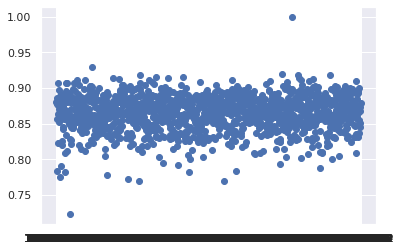

In [ ]:
id_list = []
for i in range(len(cosine_list[0])):
  id_list.append(ml_df.iloc[i]['id'])
print(id_list) 
print(len(id_list))
print(cosine_list[0])
plt.scatter(id_list, cosine_list[0])

['2002.04676', '2105.11366', '2007.12927', '2106.07914', '2108.13810']
5
[0.9295775294303894, 0.9200867414474487, 0.9187371134757996, 0.9182654023170471, 0.9181346893310547]


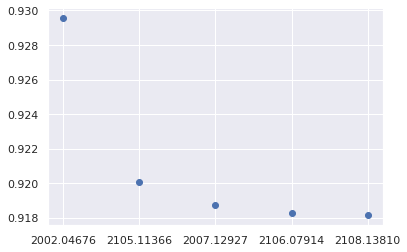

In [ ]:
id_top5_list = []
cosine_sim_list = []
for i in mxFiveIndices:
  id_top5_list.append(ml_df.iloc[i]['id'])
  cosine_sim_list.append(cosine_list[0][i])
print(id_top5_list) 
print(len(id_top5_list))
print(cosine_sim_list)
plt.scatter(id_top5_list, cosine_sim_list)